In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
plt.style.use('default')

def generate_classification_models(X, y):
    # Split data into training and testing sets
    X_train_1, X_val, y_train_1, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train_1, y_train_1, test_size=0.15, random_state=42)

    # Define models to train
    
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'XGBoosting':XGBClassifier(),
    }

    # Train and tune each model and store performance metrics
    metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [], 'ROC AUC': [], 'PR AUC': []}
    trained_models = {}
    shap_values = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        metrics['Model'].append(name)
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        metrics['F1 Score'].append(f1_score(y_test, y_pred))
        metrics['ROC AUC'].append(roc_auc_score(y_test, y_proba))
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        metrics['PR AUC'].append(auc(recall, precision))
        trained_models[name] = model
        print("Finished training: " + name)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1], [0,1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Validation and tune each model and store performance metrics
    val_metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [], 'ROC AUC': [], 'PR AUC': []}
    val_models = {}
    val_shap_values = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        val_metrics['Model'].append(name)
        val_metrics['Accuracy'].append(accuracy_score(y_val, y_pred))
        val_metrics['Precision'].append(precision_score(y_val, y_pred))
        val_metrics['Recall'].append(recall_score(y_val, y_pred))
        val_metrics['F1 Score'].append(f1_score(y_val, y_pred))
        val_metrics['ROC AUC'].append(roc_auc_score(y_val, y_proba))
        precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
        val_metrics['PR AUC'].append(auc(recall, precision))
        val_models[name] = model
        print("Finished training: " + name)
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1], [0,1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

      # Convert metrics dictionary to a pandas DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics)

     # Convert metrics dictionary to a pandas DataFrame
    val_metrics_df = pd.DataFrame.from_dict(val_metrics)

    # Return a dictionary containing the metrics DataFrame and the trained models
    return {'metrics': metrics_df, 'models': trained_models, 'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test
           ,'val_metrics': val_metrics_df, 'val_models': val_models, 'X_train': X_train, 'X_val': X_val, 'y_train': y_train, 'y_val': y_val}




def get_shap_values(model, X_test, X_train):
    explainer = shap.Explainer(model.predict_proba, X_train, feature_names=X_test.columns)
    shap_values = explainer(X_test[:100]) # just choosing the top 100 rows because this is super slow
    return shap_values

In [12]:
def get_shap_values(model, X_val, X_train):
    explainer = shap.Explainer(model.predict_proba, X_train, feature_names=X_val.columns)
    shap_values = explainer(X_val[:100]) # just choosing the top 100 rows because this is super slow
    return shap_values

In [13]:
#df = pd.read_csv('s3://adl-core-sagemaker-studio/external/MSK_marketscan/Unsaved/2023/03/24/3df268f4-1eb3-439f-8ff6-8f0f803a8b4c.csv')
df = pd.read_csv('C:\\Nag\\MarketScan_MSK\\Model_data_v3.csv')

df.shape

(295937, 15)

In [14]:
df.dropna(inplace=True)
encode = lambda x: 1 if x =='Yes' else 0
obj_cols = df.select_dtypes('object').columns
for col in obj_cols:
    df[col] = df[col].map(encode)
df.drop(columns=['enrolid'], inplace=True)

In [15]:
df.sample(10)

,surgery_flag,age,physical_therapy,knee_xray,knee_mri,knee_injection,osteoarthritis,knee_pain,knee_effusion,knee_stiffness,gait_abnormality,genu_varum,rheumatoid_arthritis,anti_inflammatory
155066,1,54,1,1,1,1,1,1,0,0,0,0,0,1
267909,0,86,0,0,0,0,0,0,0,0,0,0,0,0
230790,1,56,0,1,1,1,1,1,1,0,0,0,0,0
207908,0,85,1,1,0,1,1,1,1,0,1,0,0,1
68128,1,80,0,1,0,0,1,1,0,0,0,0,0,0
8289,0,86,1,0,0,0,0,0,0,0,0,0,0,1
85463,1,55,1,1,1,1,1,1,1,0,1,0,0,1
110191,0,50,1,0,0,1,0,0,0,0,0,0,0,1
107101,0,76,0,0,0,0,0,0,0,0,0,0,0,0
243796,1,61,0,1,0,0,0,1,0,0,0,0,0,0


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Finished training: Logistic Regression
Finished training: Decision Tree
Finished training: Random Forest
Finished training: K-Nearest Neighbors
Finished training: Gradient Boosting
[17:39:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Finished training: XGBoosting


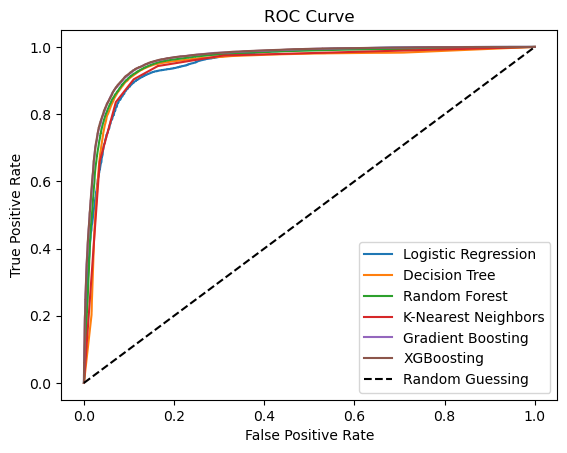

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Finished training: Logistic Regression
Finished training: Decision Tree
Finished training: Random Forest
Finished training: K-Nearest Neighbors
Finished training: Gradient Boosting
[17:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Finished training: XGBoosting


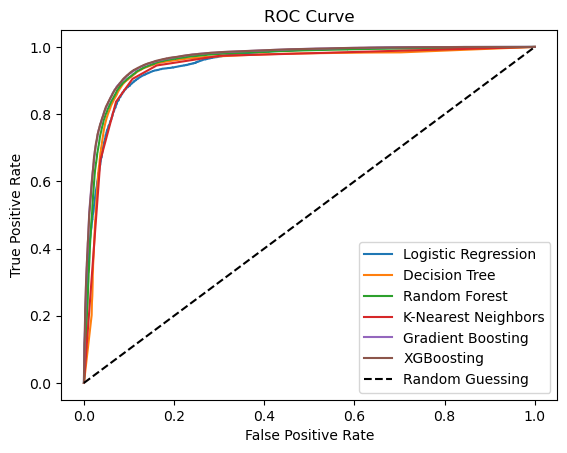

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,Logistic Regression,0.886462,0.857711,0.923999,0.889622,0.949505,0.940350
1,Decision Tree,0.902735,0.895272,0.910030,0.902591,0.943954,0.929718
2,Random Forest,0.904590,0.891874,0.918700,0.905088,0.956494,0.948109
3,K-Nearest Neighbors,0.896533,0.889152,0.903714,0.896374,0.943491,0.944208
4,Gradient Boosting,0.909361,0.897832,0.921858,0.909686,0.964510,0.959257
5,XGBoosting,0.910341,0.897284,0.924802,0.910835,0.964955,0.959768


In [16]:
X = df.drop(columns=['surgery_flag'])
y = df['surgery_flag']

metrics_obj = generate_classification_models(X, y)

metrics_obj['metrics']

In [21]:
metrics_obj['val_metrics']

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,Logistic Regression,0.887748,0.858169,0.927067,0.891289,0.950781,0.943298
1,Decision Tree,0.902931,0.895594,0.910593,0.903031,0.944785,0.930254
2,Random Forest,0.904463,0.892799,0.917718,0.905087,0.957223,0.948341
3,K-Nearest Neighbors,0.898538,0.892275,0.904829,0.898508,0.943314,0.944176
4,Gradient Boosting,0.909666,0.900178,0.920033,0.909997,0.964957,0.959435
5,XGBoosting,0.910252,0.898455,0.923573,0.910841,0.965206,0.959811


In [17]:
# pick a model and get the shap values
model = metrics_obj['models']['Logistic Regression']
X_test = metrics_obj['X_test']
X_train = metrics_obj['X_train']
y_test = metrics_obj['y_test']
y_train = metrics_obj['y_train']
shap_values = get_shap_values(model, X_test, X_train)

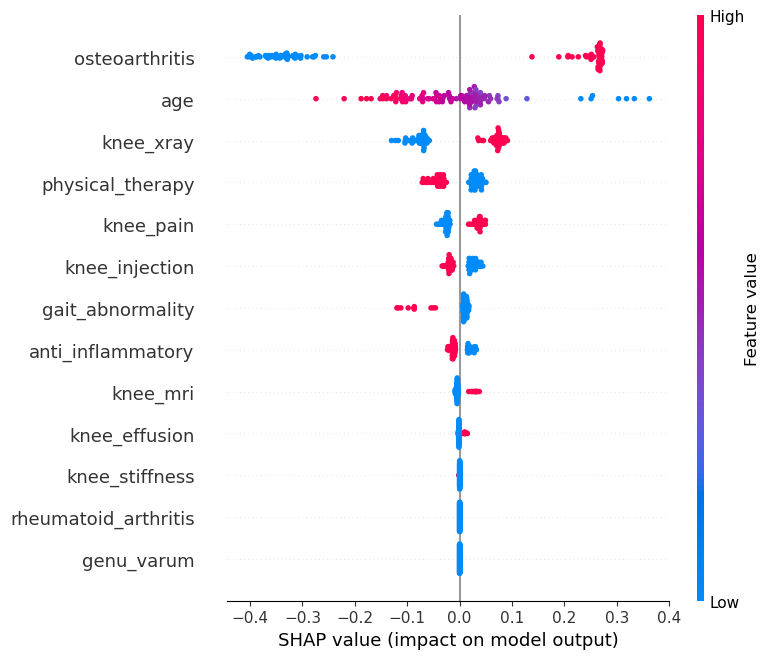

In [18]:
shap.summary_plot(shap_values[:,:,1])

0
age                     82
physical_therapy         0
knee_xray                0
knee_mri                 0
knee_injection           1
osteoarthritis           0
knee_pain                0
knee_effusion            0
knee_stiffness           0
gait_abnormality         0
genu_varum               0
rheumatoid_arthritis     0
anti_inflammatory        1
Name: 202889, dtype: int64


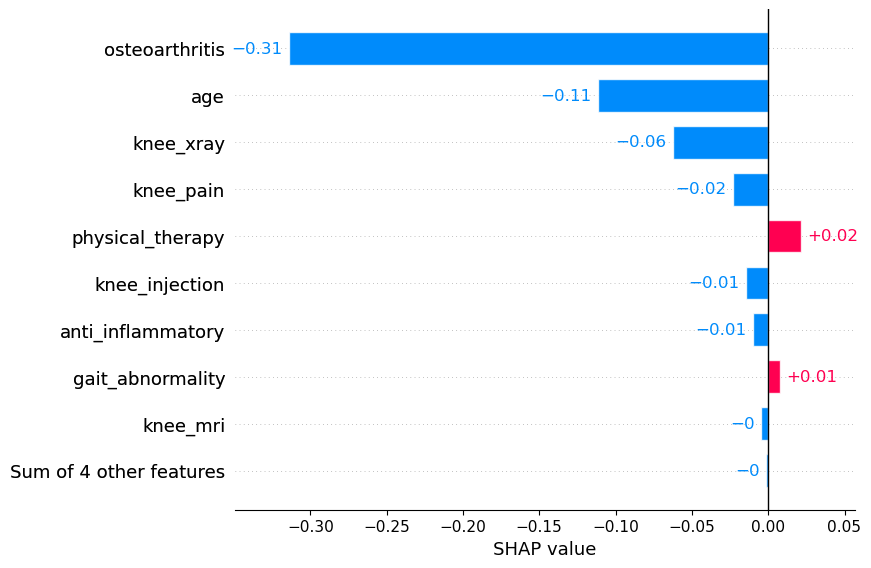

In [19]:
# Grab a random row from the test data and display the shap influence
import random
num = random.randint(0,100)
print(y_test.iloc[num])
print(X_test.iloc[num])
shap.plots.bar(shap_values[num,:,1])

In [20]:
# lasso / ridge?

### Plot a tree for example

0.9041039811687647
0.9008770140730166
0.9032405217273771


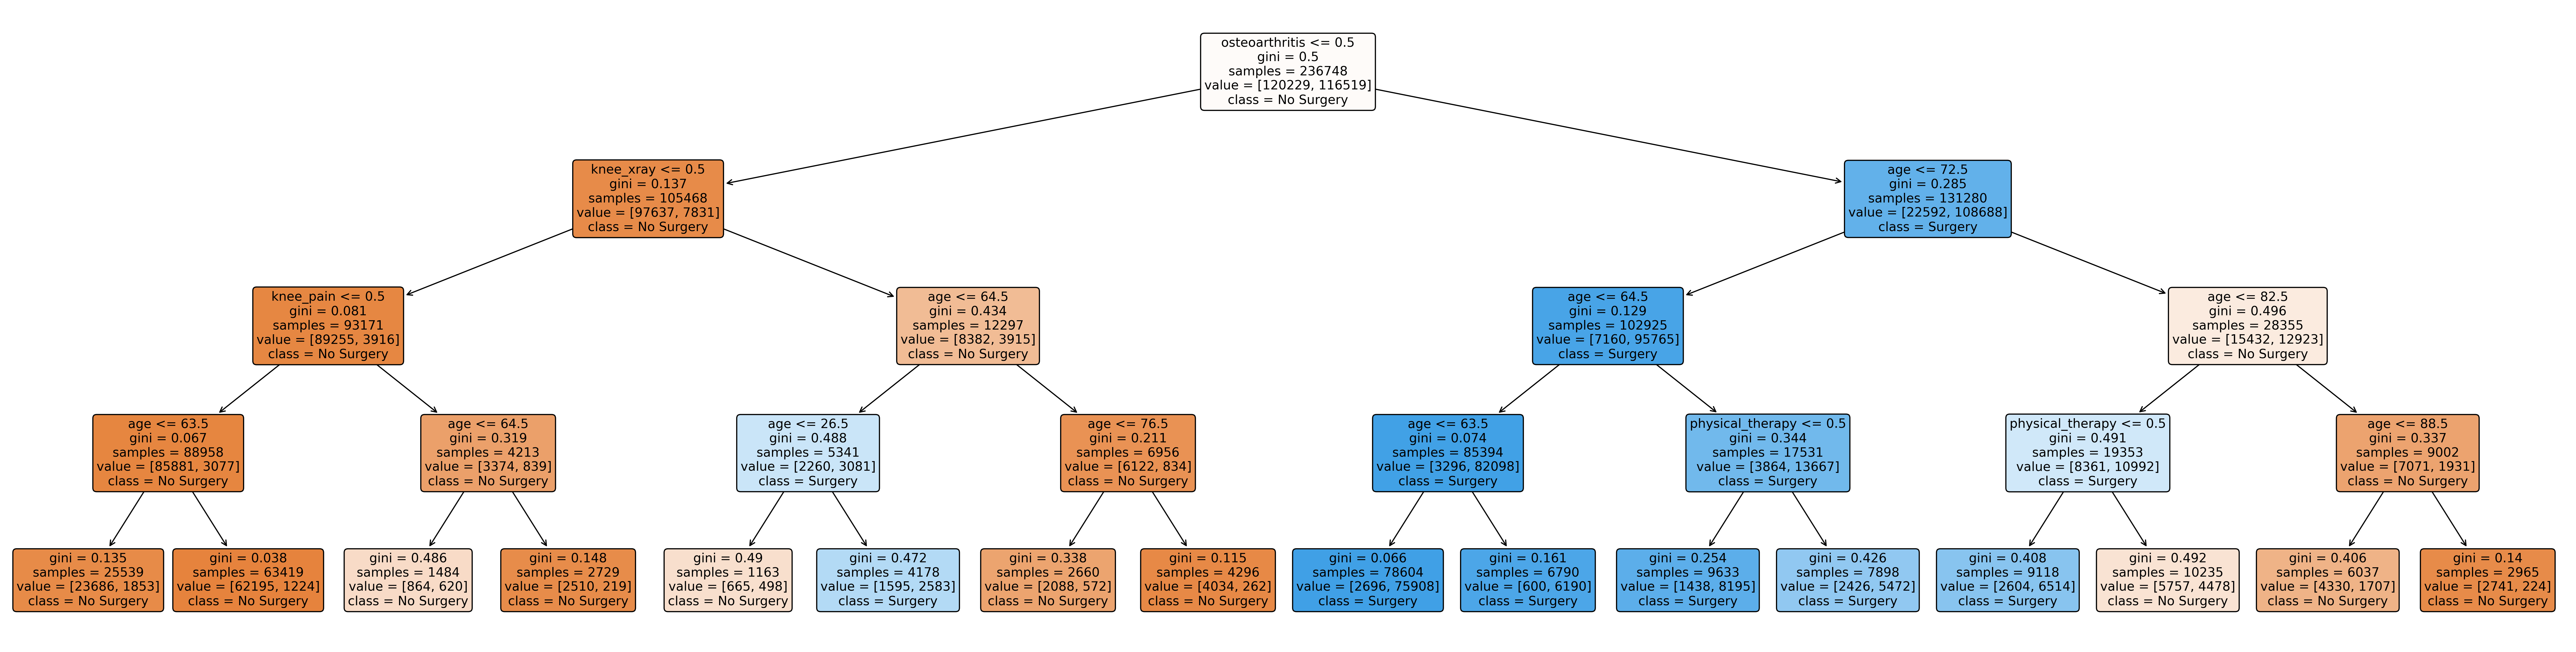

In [10]:
from sklearn import tree
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=4)
clf.fit(X_train, y_train)

precision = precision_score(y_test, clf.predict(X_test))
recall = recall_score(y_test, clf.predict(X_test))
accuracy = accuracy_score(y_test, clf.predict(X_test))

print(precision)
print(recall)
print(accuracy)

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (40,10), dpi=300)
tree.plot_tree(clf, feature_names=X_train.columns, class_names=['No Surgery', 'Surgery'], filled=True, fontsize=11, rounded=True)
plt.show()

fig.savefig('depth_4_v2.png')